In [1]:
!pip install swig
!pip install gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.7 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376422 sha256=80af64de00ff61a0c74a3d48ff419eab4bedd74ae986020ff9a0954b5509f82a
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [2]:
import gym
import torch
import numpy as np
import os
import random
from torch import nn
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, d_observation, d_action, hid):
        super(Policy, self).__init__()
        self.action = nn.Sequential(
            nn.Linear(d_observation, hid),
            nn.ReLU(),
            nn.Linear(hid, 64),
            nn.ReLU(),
            nn.Linear(64, d_action),
            nn.Softmax(dim=1),
        )
        self.critic = nn.Sequential(
            nn.Linear(d_observation, hid),
            nn.ReLU(),
            nn.Linear(hid, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

class Memory:
    def __init__(self):
        self.observations:list = []
        self.actions:list = []
        self.rewards:list = []
        self.terminated:list = []
        self.old_logprob:list = []
    def clear(self):
        del self.observations[:]
        del self.actions[:]
        del self.rewards[:]
        del self.terminated[:]
        del self.old_logprob[:]
    def append(self, observation, action, reward, terminated):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.terminated.append(terminated)
    def append_logprob(self, old_logprob):
        self.old_logprob.append(old_logprob)

    def Observation(self):
        return torch.tensor(np.array(self.observations), dtype=torch.float32).to(device)
    def Action(self):
        return torch.tensor(self.actions, dtype=torch.int64).to(device)
    def Reward(self):
        return torch.tensor(self.rewards, dtype=torch.float32).to(device)
    def Terminated(self):
        return torch.tensor(self.terminated, dtype=torch.float32).to(device)
    def Old_logprob(self):
        return torch.tensor(self.old_logprob, dtype=torch.float32).to(device)

class Agent:
    def __init__(self, device, gamma=0.99, episilon=0.2):
        self.gamma = gamma
        self.policy = Policy(8, 4, 128).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        # self.optimizer = torch.optim.Adam(self.policy.action.parameters(), lr=1e-3)
        # self.critic_optimizer = torch.optim.Adam(self.policy.critic.parameters(), lr=1e-3)
        self.memory = Memory()
        self.episilon = episilon

    def act(self, observation: torch.Tensor) -> torch.Tensor:
        prob = self.policy.action(observation)
        dist = torch.distributions.Categorical(prob)
        action = dist.sample()
        logprob = dist.log_prob(action).squeeze()  # [1]
        self.memory.append_logprob(logprob)
        return action.item()

    def evaluate(self, observation: torch.Tensor, action: torch.Tensor) -> tuple[torch.Tensor]:
        prob = self.policy.action(observation)
        dist = torch.distributions.Categorical(prob)
        logprob = dist.log_prob(action).squeeze()  # [episode_length]
        value = self.policy.critic(observation).squeeze()  # [episode_length]
        return logprob, value


    def update(self, k_epoch=5):
        def normalize(x: torch.Tensor, episilon=1e-5) -> torch.Tensor:
            return (x - x.mean())/(x.std()+episilon)

        def discount(self, rewards: torch.Tensor, terminated: torch.Tensor) -> torch.Tensor:
            discount_reward = []
            r_tmp = 0
            for i in range(rewards.shape[0]-1, -1, -1):
                if terminated[i] == 1:
                    r_tmp = 0
                r_tmp = rewards[i] + self.gamma * r_tmp
                discount_reward.insert(0, r_tmp)
            return torch.stack(discount_reward)

        discount_reward = discount(self, self.memory.Reward(), self.memory.Terminated())
        discount_reward = normalize(discount_reward)
        old_logprob = self.memory.Old_logprob()

        mean_loss = 0
        for _ in range(k_epoch):
            logprob, value = self.evaluate(self.memory.Observation(), self.memory.Action())
            advantage = discount_reward - value
            advantage = normalize(advantage)
            ratio = torch.exp(logprob - old_logprob.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.episilon, 1+self.episilon) * advantage
            loss = -torch.min(surr1, surr2) + nn.MSELoss()(value, discount_reward)
            # loss = -advantage * logprob + nn.MSELoss()(value, discount_reward)
            # loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            mean_loss += loss.item()

            # critic_loss = nn.MSELoss()(value, discount_reward)
            # self.critic_optimizer.zero_grad()
            # critic_loss.backward()
            # self.critic_optimizer.step()

            print("\rEpoch: {}, Loss: {}".format(_, loss.item()), end="")

        self.memory.clear()
        return mean_loss/k_epoch

    def append(self, *kwargs):
        self.memory.append(*kwargs)

    def save(self, model_name):
        torch.save(self.policy.state_dict(), model_name)

if __name__ == "__main__":
    test = False
    if not test:
        env = gym.make("LunarLander-v2", render_mode="rgb_array")
        agent = Agent(device)
        Num_episode = 1000
        episode_length = 1000
        score_hist = []
        time_steps_per_episode = []
        n_steps = 0
        for episode in range(Num_episode):
            print("\nEpisode: {}".format(episode))
            total_reward = 0
            rounds = 1
            observation = env.reset()
            for t in range(episode_length):
                action = agent.act(torch.tensor(observation)[None,:].to(device))
                new_observation, reward, terminated, truncated = env.step(action)
                agent.append(observation, action, reward, terminated)
                total_reward += reward
                observation = new_observation
                n_steps += 1
                if terminated:
                    observation = env.reset()
                    rounds += 1
            score_hist.append(total_reward)
            time_steps_per_episode.append(n_steps)
            print("\nEpisode: {}, Mean_Reward: {}, Rounds: {}".format(episode, total_reward/rounds, rounds))
            loss = agent.update()
        env.close()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprec


Episode: 0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



Episode: 0, Mean_Reward: -151.0700895021741, Rounds: 12
Epoch: 4, Loss: 0.9520063400268555
Episode: 1

Episode: 1, Mean_Reward: -140.16380744167446, Rounds: 13
Epoch: 4, Loss: 0.9063276648521423
Episode: 2

Episode: 2, Mean_Reward: -129.19329381310033, Rounds: 12
Epoch: 4, Loss: 0.9407180547714233
Episode: 3

Episode: 3, Mean_Reward: -128.68766237181174, Rounds: 12
Epoch: 4, Loss: 0.861968994140625
Episode: 4

Episode: 4, Mean_Reward: -124.05845744694416, Rounds: 11
Epoch: 4, Loss: 1.0313223600387573
Episode: 5

Episode: 5, Mean_Reward: -159.86575630958285, Rounds: 12
Epoch: 4, Loss: 0.9366216063499451
Episode: 6

Episode: 6, Mean_Reward: -144.83532329797833, Rounds: 11
Epoch: 4, Loss: 0.9058759808540344
Episode: 7

Episode: 7, Mean_Reward: -144.6565835190515, Rounds: 12
Epoch: 4, Loss: 0.9649721384048462
Episode: 8

Episode: 8, Mean_Reward: -160.87078351576767, Rounds: 11
Epoch: 4, Loss: 0.8964194059371948
Episode: 9

Episode: 9, Mean_Reward: -109.1735163762629, Rounds: 12
Epoch: 4, 

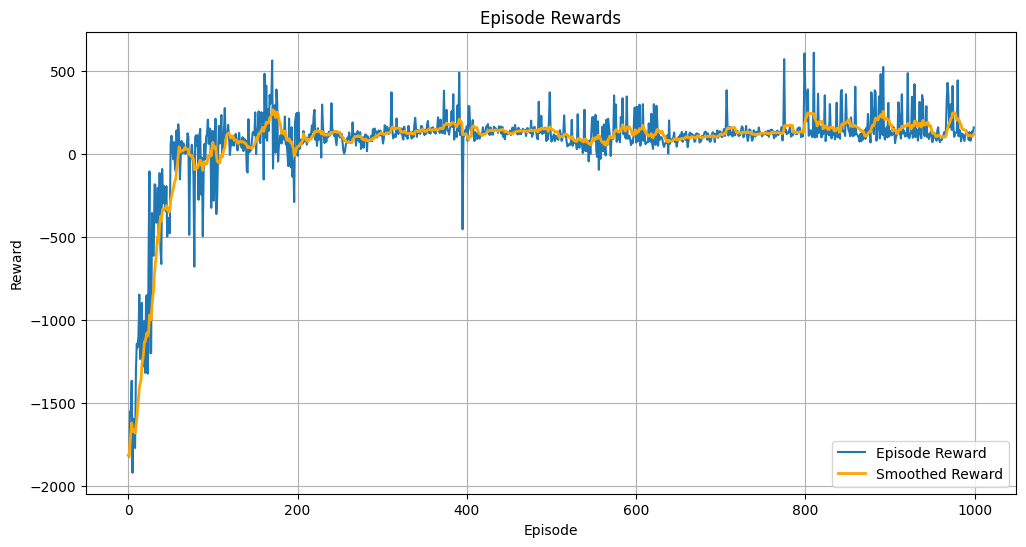

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(score_hist, label="Episode Reward")
smoothed_rewards = [np.mean(score_hist[max(0, i-10):i+1]) for i in range(len(score_hist))]
plt.plot(smoothed_rewards, label="Smoothed Reward", color="orange", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.legend()
plt.grid()
plt.show()